In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [3]:
IT_nonfinance = pd.read_excel('./data/dongboo/비재무/IT_비재무_TOTAL_최종.xlsx')
IT_validation_nonfinance = pd.read_excel('./data/dongboo/비재무validation/validation_비재무_it_total_최종.xlsx')

In [4]:
# 
IT_stock = pd.read_excel('./data/dongboo/IT_주가_total_krx.xlsx')

IT_validation_stock = pd.read_excel('./data/dongboo/IT_validation_주가.xls')

In [5]:
IT = pd.merge(IT_nonfinance,IT_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])

IT_val = pd.merge(IT_validation_nonfinance,IT_validation_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])


In [6]:
#del IT['주식매입선택권.1']

# 회사별로 분리

In [7]:
lg = IT[IT['회사명'] == 'LG이노텍(주)']
sdi = IT[IT['회사명'] == '삼성SDI(주)']
ssem = IT[IT['회사명'] == '삼성전기(주)']
hynix = IT[IT['회사명'] == '에스케이하이닉스(주)']

# ------------- validation ------------------

samsungelectric = IT_val[IT_val['회사명'] == '삼성전자(주)']
lgelectric = IT_val[IT_val['회사명'] == '엘지전자(주)']
sds = IT_val[IT_val['회사명'] == '삼성에스디에스(주)']
lgdisplay = IT_val[IT_val['회사명'] == '엘지디스플레이(주)']

In [8]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [9]:
classify(lg)
classify(sdi)
classify(ssem)
classify(hynix)

# ------------- validation ------------------

classify(samsungelectric)
classify(lgelectric)
classify(sds)
classify(lgdisplay)

,회사명,거래소코드,회계년도,주식의 종류,발행할 주식의 총수(주),현재까지 발행한 주식의 총수(주),현재까지 감소한 주식의 총수(주),유통주식수 (발행주식의 총수 - 자기주식수)(주),이익소각(주),발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),자기주식수(주),정규+무기계약_기말인원(남)(명),정규+무기계약_기말인원(여)(명),정규+무기계약_기말인원(명),기간제_기말인원(남)(명),기간제_기말인원(여)(명),기간제_기말인원(명),합계_기말인원_남(명),합계_기말인원_여(명),합계_기말인원(명),합계_년간평균급여(천원),합계_1인평균년간급여(천원),합계_평균근속연수,최고가,최저가,종가,거래량,거래대금,3개월후종가,분기수익률,수익률상승하락
0,엘지디스플레이(주),34220,2010/12,10,500000000,357815700,0,357815700,0,357815700,0,20995,9122,30117,0,0,0,20995,9122,30117,1282387000,42000,4.3,41700,38900,40300,50464767,2033069299170,35075.0,-0.129653,0.0
1,엘지디스플레이(주),34220,2011/03,10,500000000,357815700,0,357815700,0,357815700,0,22503,9818,32321,0,0,0,22503,9818,32321,516829000,16000,4.1,36500,33650,35075,59481024,2079282228250,31625.0,-0.098361,0.0
2,엘지디스플레이(주),34220,2011/06,10,500000000,357815700,0,357815700,0,357815700,0,23982,10136,34118,0,0,0,23982,10136,34118,869415000,27000,4.1,35200,28050,31625,75248275,2336593713600,19525.0,-0.382609,0.0
3,엘지디스플레이(주),34220,2011/09,10,500000000,357815700,0,357815700,0,357815700,0,24130,10512,34642,0,0,0,24130,10512,34642,1214680000,37000,4.3,21550,17500,19525,65141512,1275308524800,24275.0,0.243278,1.0
4,엘지디스플레이(주),34220,2011/12,10,500000000,357815700,0,357815700,0,357815700,0,24195,10608,34803,0,0,0,24195,10608,34803,1562234000,47000,4.5,26300,22250,24275,54301825,1309194344350,28000.0,0.153450,1.0
5,엘지디스플레이(주),34220,2012/03,10,500000000,357815700,0,357815700,0,357815700,0,24217,10596,34813,0,0,0,24217,10596,34813,438722000,13000,4.2,29650,26350,28000,56698931,1593347436250,21575.0,-0.229464,0.0
6,엘지디스플레이(주),34220,2012/06,10,500000000,357815700,0,357815700,0,357815700,0,24229,10603,34832,0,0,0,24229,10603,34832,801731000,23000,4.4,23100,20050,21575,44686364,977616803750,27725.0,0.285052,1.0
7,엘지디스플레이(주),34220,2012/09,10,500000000,357815700,0,357815700,0,357815700,0,23969,10665,34634,0,0,0,23969,10665,34634,1173078000,34000,4.6,29400,26050,27725,45288195,1262835728640,32550.0,0.174031,1.0
8,엘지디스플레이(주),34220,2012/12,10,500000000,357815700,0,357815700,0,357815700,0,23978,10679,34657,0,0,0,23978,10679,34657,1653773000,47000,4.7,35400,29700,32550,48483018,1560545926825,31475.0,-0.033026,0.0
9,엘지디스플레이(주),34220,2013/03,10,500000000,357815700,0,357815700,0,357815700,0,24278,10436,34714,0,0,0,24278,10436,34714,478460000,14000,4.9,33050,29900,31475,40348389,1281195813400,28950.0,-0.080222,0.0


In [10]:
lg = lg.iloc[:-1,:]
sdi = sdi.iloc[:-1,:]
ssem = ssem.iloc[:-1,:]
hynix = hynix.iloc[:-1,:]

# ------------- validation ------------------

samsungelectric = samsungelectric.iloc[:-1,:]
lgelectric = lgelectric.iloc[:-1,:]
sds = sds.iloc[:-1,:]
lgdisplay = lgdisplay.iloc[:-1,:]

# 산업별 변수 <3개월 후 종가>와의 상관관계 분석

In [11]:
# 밑에 함수로 해보기!!!!

In [12]:
lg_corr = lg.corr(method = 'pearson')
df_lg = pd.DataFrame(lg_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg.columns = ['지표','3개월후종가']

sdi_corr = sdi.corr(method = 'pearson')
df_sdi = pd.DataFrame(sdi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi.columns = ['지표','3개월후종가']

ssem_corr = ssem.corr(method = 'pearson')
df_ssem = pd.DataFrame(ssem_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem.columns = ['지표','3개월후종가']

hynix_corr = hynix.corr(method = 'pearson')
df_hynix = pd.DataFrame(hynix_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix.columns = ['지표','3개월후종가']

# 산업별 상관관계 데이터프레임

In [13]:
pd.concat([df_lg.reset_index(drop = True), df_sdi.reset_index(drop = True), df_ssem.reset_index(drop = True), df_hynix.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,최고가,0.767493,최고가,0.832185,최고가,0.814126,종가,0.948256
2,종가,0.747660,종가,0.820868,종가,0.800776,최고가,0.947936
3,최저가,0.712841,자기주식수(주),0.813923,최저가,0.777085,최저가,0.944148
4,거래대금,0.686572,최저가,0.792540,거래대금,0.662196,합계_기말인원(명),0.833872
5,거래량,0.598758,기간제_기말인원(명),0.480034,거래량,0.493290,합계_평균근속연수,0.788733
6,분기수익률,0.371295,거래대금,0.441876,수익률상승하락,0.394310,기간제_기말인원(명),0.740025
7,기간제_기말인원(여)(명),0.348528,분기수익률,0.407930,분기수익률,0.383191,기간제_기말인원(남)(명),0.720481
8,기간제_기말인원(명),0.308102,합계_평균근속연수,0.407035,정규+무기계약_기말인원(남)(명),0.380587,정규+무기계약_기말인원(남)(명),0.697375
9,합계_기말인원(명),0.283486,기간제_기말인원(남)(명),0.386057,정규+무기계약_기말인원(명),0.362591,합계_기말인원_남(명),0.669612


In [14]:
list_corr = []
order = 20 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg.index[:order])):
    list_corr.append(df_lg.index[:order][i])
    list_corr.append(df_sdi.index[:order][i])
    list_corr.append(df_ssem.index[:order][i])
    list_corr.append(df_hynix.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [15]:
var = []
for i in range(len(variable)):
    var.append(df_lg[df_lg.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [16]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]

In [17]:
corr = corr[corr['var'] != '3개월후종가'].reset_index(drop = True)
corr = corr[corr['var'] != '수익률상승하락'].reset_index(drop = True)
corr = corr[corr['var'] != '분기수익률'].reset_index(drop = True)
corr

,var_index,var,number
0,12,기간제_기말인원(남)(명),4
1,25,거래대금,4
2,23,종가,4
3,22,최저가,4
4,21,최고가,4
5,20,합계_평균근속연수,4
6,5,유통주식수 (발행주식의 총수 - 자기주식수)(주),4
7,18,합계_년간평균급여(천원),4
8,17,합계_기말인원(명),4
9,15,합계_기말인원_남(명),4


# 위 자료를 보고 변수 선정

In [18]:
deep_lg = lg[corr['var'][0:18]]
deep_sdi = sdi[corr['var'][0:18]]
deep_ssem = ssem[corr['var'][0:18]]
deep_hynix = hynix[corr['var'][0:18]]

deep_lg['수익률상승하락'] = lg['수익률상승하락']
deep_sdi['수익률상승하락'] = sdi['수익률상승하락']
deep_ssem['수익률상승하락'] = ssem['수익률상승하락']
deep_hynix['수익률상승하락'] = hynix['수익률상승하락']

# ------------ validation --------------

deep_samsungelectric = samsungelectric[corr['var'][0:18]]
deep_lgelectric = lgelectric[corr['var'][0:18]]
deep_sds = sds[corr['var'][0:18]]
deep_lgdisplay = lgdisplay[corr['var'][0:18]]

deep_samsungelectric['수익률상승하락'] = samsungelectric['수익률상승하락']
deep_lgelectric['수익률상승하락'] = lgelectric['수익률상승하락']
deep_sds['수익률상승하락'] = sds['수익률상승하락']
deep_lgdisplay['수익률상승하락'] = lgdisplay['수익률상승하락']

In [19]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_lg = StandardScaler()
scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))

scaler_sdi = StandardScaler()
scale_sdi = pd.DataFrame(scaler_sdi.fit_transform(deep_sdi.iloc[:,:-1]))

scaler_ssem = StandardScaler()
scale_ssem = pd.DataFrame(scaler_ssem.fit_transform(deep_ssem.iloc[:,:-1]))

scaler_hynix = StandardScaler()
scale_hynix = pd.DataFrame(scaler_hynix.fit_transform(deep_hynix.iloc[:,:-1]))

# ------------ validation --------------

scaler_samsungelectric = StandardScaler()
scale_samsungelectric = pd.DataFrame(scaler_lg.fit_transform(deep_samsungelectric.iloc[:,:-1]))

scaler_lgelectric = StandardScaler()
scale_lgelectric = pd.DataFrame(scaler_sdi.fit_transform(deep_lgelectric.iloc[:,:-1]))

scaler_sds = StandardScaler()
scale_sds = pd.DataFrame(scaler_ssem.fit_transform(deep_sds.iloc[:,:-1]))

scaler_lgdisplay = StandardScaler()
scale_lgdisplay = pd.DataFrame(scaler_hynix.fit_transform(deep_lgdisplay.iloc[:,:-1]))


# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [20]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

# ------------ validation --------------

# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT_validation = pd.concat([deep_samsungelectric,deep_lgelectric,deep_sds,deep_lgdisplay], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT_validation = pd.concat([scale_samsungelectric,scale_lgelectric,scale_sds,scale_lgdisplay], ignore_index=True)


# 샤비어함수 및 히든레이어 5개

# 및 Validation

In [21]:
def xavier_init(n_inputs, n_outputs, uniform=True):
    if uniform:
        # 6 was used in the paper.
        init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limints as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

In [22]:
# 히든레이어 1개 짜리!!!!

# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_IT
y_data = deep_IT.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.001


X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 1], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([1]))

hypothesis = tf.sigmoid(tf.matmul(X, W1) + b1)


# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [23]:
# # 히든레이어 5개 짜리!!!

# # Review : Learning rate and Evaluation
# import tensorflow as tf
# import random
# import matplotlib.pyplot as plt

# tf.set_random_seed(777)  # reproducibility
# tf.reset_default_graph()


# x_data = scale_IT
# y_data = deep_IT.iloc[:,[-1]]


# # parameters
# placeholder_num = len(x_data.columns)
# learning_rate = 0.001




# X = tf.placeholder(tf.float32, [None, placeholder_num])
# Y = tf.placeholder(tf.float32, [None, 1])
# keep_prob = tf.placeholder(tf.float32)


# W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
# b1 = tf.Variable(tf.random_normal([32]))
# L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
# L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


# W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
# b2 = tf.Variable(tf.random_normal([64]))
# L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
# L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

# W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
# b3 = tf.Variable(tf.random_normal([64]))
# L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
# L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


# W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
# b4 = tf.Variable(tf.random_normal([32]))
# L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
# L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


# W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
# b5 = tf.Variable(tf.random_normal([1]))
# L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# # hypothesis = tf.matmul(L4, W5) + b5

# # define cost/loss & optimizer

# # Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
# hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# # cost/loss function
# cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
#                        tf.log(1 - hypothesis))

# train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# # train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# # Accuracy computation
# # True if hypothesis>0.5 else False
# predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
# accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

# <span style="color:red"> 가치주로 validation

In [24]:
# Launch graph

validation_number = 20

graph_cost = []
graph_acc = []

x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)


with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(50001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data_train, Y: y_data_train, keep_prob: 0.8})       
        h, c, a = sess.run([hypothesis, predicted, accuracy], feed_dict={X: x_data_test, Y: y_data_test, keep_prob: 1.0})
        graph_cost.append(cost_val)
        graph_acc.append(a)
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

Step : 0 	 Cost : 0.9175519347190857 	 Acc : 68.00000071525574
Step : 1 	 Cost : 0.9174305200576782 	 Acc : 68.00000071525574
Step : 2 	 Cost : 0.9173091650009155 	 Acc : 68.00000071525574
Step : 3 	 Cost : 0.9171879887580872 	 Acc : 68.00000071525574
Step : 4 	 Cost : 0.9170668125152588 	 Acc : 68.00000071525574
Step : 5 	 Cost : 0.9169456362724304 	 Acc : 68.00000071525574
Step : 6 	 Cost : 0.9168245196342468 	 Acc : 68.00000071525574
Step : 7 	 Cost : 0.9167032837867737 	 Acc : 68.00000071525574
Step : 8 	 Cost : 0.9165822863578796 	 Acc : 68.00000071525574
Step : 9 	 Cost : 0.9164612889289856 	 Acc : 68.00000071525574
Step : 200 	 Cost : 0.8940527439117432 	 Acc : 68.00000071525574
Step : 400 	 Cost : 0.8720611929893494 	 Acc : 68.00000071525574
Step : 600 	 Cost : 0.8515278697013855 	 Acc : 68.00000071525574
Step : 800 	 Cost : 0.8324017524719238 	 Acc : 68.00000071525574
Step : 1000 	 Cost : 0.8146288394927979 	 Acc : 68.00000071525574
Step : 1200 	 Cost : 0.7981511354446411 	 Ac

Step : 22800 	 Cost : 0.5923290252685547 	 Acc : 40.00000059604645
Step : 23000 	 Cost : 0.5922089219093323 	 Acc : 40.00000059604645
Step : 23200 	 Cost : 0.592090368270874 	 Acc : 40.00000059604645
Step : 23400 	 Cost : 0.5919731855392456 	 Acc : 40.00000059604645
Step : 23600 	 Cost : 0.5918574333190918 	 Acc : 40.00000059604645
Step : 23800 	 Cost : 0.5917431116104126 	 Acc : 40.00000059604645
Step : 24000 	 Cost : 0.5916300415992737 	 Acc : 40.00000059604645
Step : 24200 	 Cost : 0.5915182828903198 	 Acc : 40.00000059604645
Step : 24400 	 Cost : 0.591407835483551 	 Acc : 40.00000059604645
Step : 24600 	 Cost : 0.5912986397743225 	 Acc : 40.00000059604645
Step : 24800 	 Cost : 0.5911906361579895 	 Acc : 40.00000059604645
Step : 25000 	 Cost : 0.591083824634552 	 Acc : 40.00000059604645
Step : 25200 	 Cost : 0.5909782648086548 	 Acc : 40.00000059604645
Step : 25400 	 Cost : 0.5908737182617188 	 Acc : 40.00000059604645
Step : 25600 	 Cost : 0.5907703042030334 	 Acc : 40.0000005960464

Step : 47200 	 Cost : 0.5833314657211304 	 Acc : 40.00000059604645
Step : 47400 	 Cost : 0.5832829475402832 	 Acc : 40.00000059604645
Step : 47600 	 Cost : 0.5832346081733704 	 Acc : 40.00000059604645
Step : 47800 	 Cost : 0.5831865072250366 	 Acc : 40.00000059604645
Step : 48000 	 Cost : 0.583138644695282 	 Acc : 40.00000059604645
Step : 48200 	 Cost : 0.5830909013748169 	 Acc : 40.00000059604645
Step : 48400 	 Cost : 0.5830435156822205 	 Acc : 40.00000059604645
Step : 48600 	 Cost : 0.5829963088035583 	 Acc : 40.00000059604645
Step : 48800 	 Cost : 0.5829492211341858 	 Acc : 40.00000059604645
Step : 49000 	 Cost : 0.5829024910926819 	 Acc : 40.00000059604645
Step : 49200 	 Cost : 0.5828558802604675 	 Acc : 40.00000059604645
Step : 49400 	 Cost : 0.5828095078468323 	 Acc : 40.00000059604645
Step : 49600 	 Cost : 0.5827633142471313 	 Acc : 40.00000059604645
Step : 49800 	 Cost : 0.5827174186706543 	 Acc : 40.00000059604645
Step : 50000 	 Cost : 0.5826715230941772 	 Acc : 40.00000059604

In [25]:
print('모델 최고 정확도: ', max(graph_acc) * 100 , '%')

모델 최고 정확도:  68.00000071525574 %


In [26]:
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title

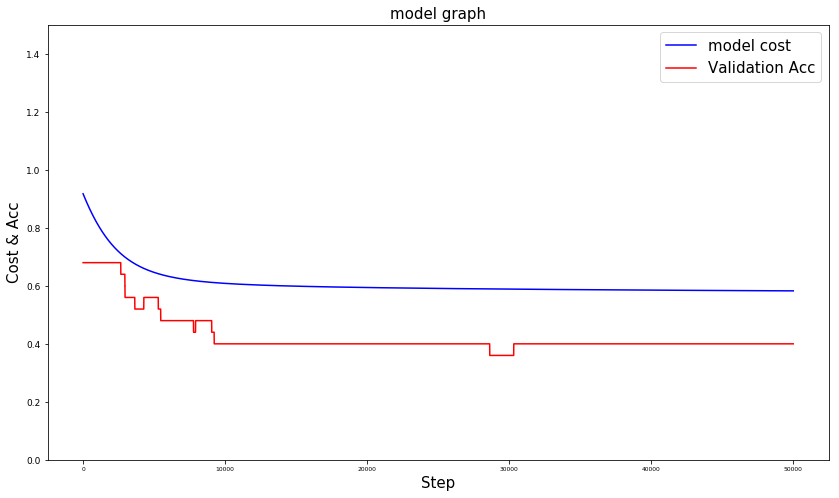

In [27]:
plt.figure(figsize=(14, 8))
plt.ylim([0,1.5])
plt.plot(graph_cost, color = 'blue', label = 'model cost')
plt.plot(graph_acc, color = 'red', label = 'Validation Acc')
plt.title('model graph')
plt.xlabel('Step')
plt.ylabel('Cost & Acc')
plt.legend()
plt.show()

In [28]:
pd.DataFrame({'graph_cost':graph_cost,'graph_acc': graph_acc})

,graph_cost,graph_acc
0,0.917552,0.68
1,0.917431,0.68
2,0.917309,0.68
3,0.917188,0.68
4,0.917067,0.68
5,0.916946,0.68
6,0.916825,0.68
7,0.916703,0.68
8,0.916582,0.68
9,0.916461,0.68


In [29]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data_test.values.ravel()),'predict': list(c.ravel())})

,real,predict
0,0.0,1.0
1,0.0,1.0
2,1.0,1.0
3,0.0,1.0
4,1.0,0.0
5,0.0,0.0
6,1.0,1.0
7,0.0,1.0
8,1.0,1.0
9,0.0,0.0


# <span style="color:red"> 비 가치주로 validation

In [30]:
# Launch graph


graph_cost = []
graph_acc = []

# samsungelectric / lgelectric / sds / lgdisplay

# x_val_data = scale_lgdisplay
# y_val_data = deep_lgdisplay.iloc[:,[-1]]

x_val_data = scale_IT_validation
y_val_data = deep_IT_validation.iloc[:,[-1]]

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(12001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data, Y: y_data, keep_prob: 0.8})
        h, c, a = sess.run([hypothesis, predicted, accuracy],
                               feed_dict={X: x_val_data, Y: y_val_data, keep_prob: 1.0})
        graph_cost.append(cost_val)
        graph_acc.append(a)
        if step % 200 == 0 or step < 10 :
            
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

    # Accuracy report
   

Step : 0 	 Cost : 1.0777888298034668 	 Acc : 47.22222089767456
Step : 1 	 Cost : 1.0774003267288208 	 Acc : 47.22222089767456
Step : 2 	 Cost : 1.077012062072754 	 Acc : 47.22222089767456
Step : 3 	 Cost : 1.0766236782073975 	 Acc : 47.22222089767456
Step : 4 	 Cost : 1.076236367225647 	 Acc : 47.22222089767456
Step : 5 	 Cost : 1.0758486986160278 	 Acc : 47.22222089767456
Step : 6 	 Cost : 1.0754616260528564 	 Acc : 47.22222089767456
Step : 7 	 Cost : 1.0750749111175537 	 Acc : 47.22222089767456
Step : 8 	 Cost : 1.0746883153915405 	 Acc : 47.22222089767456
Step : 9 	 Cost : 1.074302077293396 	 Acc : 47.22222089767456
Step : 200 	 Cost : 1.006054401397705 	 Acc : 45.37037014961243
Step : 400 	 Cost : 0.9459854960441589 	 Acc : 45.37037014961243
Step : 600 	 Cost : 0.8966267108917236 	 Acc : 46.296295523643494
Step : 800 	 Cost : 0.8566320538520813 	 Acc : 45.37037014961243
Step : 1000 	 Cost : 0.8244688510894775 	 Acc : 44.44444477558136
Step : 1200 	 Cost : 0.7986243367195129 	 Acc :

In [31]:
print('모델 최고 정확도: ', max(graph_acc) * 100 , '%')

모델 최고 정확도:  61.11111044883728 %


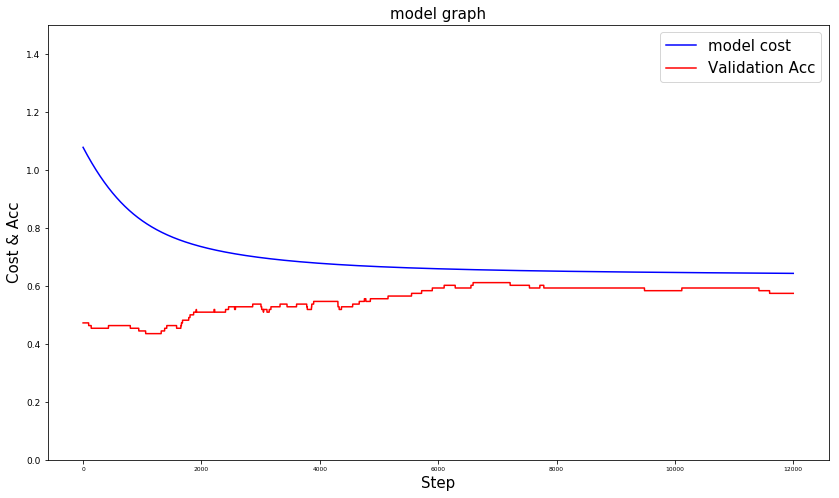

In [32]:
plt.figure(figsize=(14, 8))
plt.ylim([0,1.5])
plt.plot(graph_cost, color = 'blue', label = 'model cost')
plt.plot(graph_acc, color = 'red', label = 'Validation Acc')
plt.title('model graph')
plt.xlabel('Step')
plt.ylabel('Cost & Acc')
plt.legend()
plt.show()

In [33]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_val_data.iloc[:,:].values.ravel()),'predict': list(c.ravel())})

,real,predict
0,1.0,1.0
1,0.0,1.0
2,0.0,1.0
3,1.0,1.0
4,1.0,1.0
5,0.0,1.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,0.0,0.0
